In [ ]:
"""
Meta-regression model
Uses predictions of various models
"""

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import make_pipeline
from loader import loader_train, loader_test, train_validation_split
from transforms import MinEditDistance, Vectorizer, LemmaTransform, FuncTransform, Mixor, \
                        SynonymTransform, POSTransform, BaseTransform, ProcessingVocab, \
                        EmbeddingTransform, TokenTransform, EncoderTransform, BERTProcessing
from models import BowModel, CosineSimilarity, build_matrix, SiameseLSTM, BERTModel, MLPEstimator
from evaluation import evaluate_model, spearman_measure
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
import joblib
import tensorflow as tf
import shap
shap.initjs()

Using TensorFlow backend.
C:\Program Files\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Program Files\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Program Files\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Program Files\Python\lib\site-packages\tensorflow\python\framework\dtypes.py:519

ModuleNotFoundError: No module named 'shap'

In [ ]:
def compute_basic_features(dfX):
    """Compute predictions for the most basic models (those that don't need any label)"""
    features = ['Counts_CS', 'TFIDF_CS', 'TFIDF_MLP', 'W2V_sum_CS',
            'POS_TFIDF_CS', 'Syn_Counts_CS', 'Syn_TFIDF_CS', 'Lemmas_Counts_CS', 
            'Lemmas_TFIDF_CS', 'POS_IMED', 'IMED']
    df_features = pd.DataFrame([], columns=features, index=dfX.index)
    df_features['Counts_CS'] = BowModel(ponderation='count').predict(dfX)
    df_features['TFIDF_CS'] = BowModel(ponderation='tfidf').predict(dfX)
    df_features['POS_TFIDF_CS'] = make_pipeline(POSTransform(tags_only=True, join_labels=True), 
                                                Vectorizer(ponderation='tfidf'), 
                                                CosineSimilarity()).predict(dfX)
    df_features['Syn_Counts_CS'] = make_pipeline(SynonymTransform(),
                                                 Vectorizer(ponderation='count'), 
                                                 CosineSimilarity()).predict(dfX)
    df_features['Syn_TFIDF_CS'] = make_pipeline(SynonymTransform(),
                                                Vectorizer(ponderation='tfidf'), 
                                                CosineSimilarity()).predict(dfX)
    df_features['Lemmas_Counts_CS'] = make_pipeline(LemmaTransform(),
                                                Vectorizer(ponderation='count'), 
                                                CosineSimilarity()).predict(dfX)
    df_features['Lemmas_TFIDF_CS'] = make_pipeline(LemmaTransform(),
                                               Vectorizer(ponderation='tfidf'), 
                                                CosineSimilarity()).predict(dfX)
    df_features['IMED'] = make_pipeline(MinEditDistance(), 
                                        FuncTransform(lambda x:1/(1+np.sqrt(x)))).transform(dfX)
    df_features['POS_IMED'] = make_pipeline(POSTransform(tags_only=True, join_labels=True), MinEditDistance(),
                                            FuncTransform(lambda x:1/(1+np.sqrt(x)))).transform(dfX)
    df_features['W2V_sum_CS'] = make_pipeline(TokenTransform(), EmbeddingTransform(method=sum), 
                                              CosineSimilarity()).predict(dfX)
    return df_features

# Load data

In [ ]:
# Load the same data from the previous predictions
dfX_train = joblib.load('data/dfX_train.dump')
dfX_val = joblib.load('data/dfX_val.dump')
y_train = joblib.load('data/y_train.dump')/5 # normalization
y_val = joblib.load('data/y_val.dump')/5 # normalization
dfX, y = loader_train()
vocab = ProcessingVocab(dfX).voc()
dfX_test = loader_test()

# Train individual regressors

### MLP model

In [ ]:
MLP_model = make_pipeline(Vectorizer(ponderation='tfidf'), Mixor(method='sum'),
                                            TruncatedSVD(n_components=1000), MLPEstimator())

In [23]:
MLP_model.fit(dfX_train, y_train)
y_pred_MLP_val = MLP_model.predict(dfX_val)
y_pred_MLP_test = MLP_model.predict(dfX_test)

Train on 3635 samples, validate on 642 samples
Epoch 1/20
3635/3635 [==============================] - 1s 313us/step - loss: 0.1474 - mse: 0.1474 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 2/20
 864/3635 [======>.......................] - ETA: 0s - loss: 0.0683 - mse: 0.0683

C:\Program Files\Python\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_mse,loss,mse
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3635/3635 [==============================] - 1s 192us/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 3/20
3635/3635 [==============================] - 1s 193us/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 4/20
3635/3635 [==============================] - 1s 197us/step - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 5/20
3635/3635 [==============================] - 1s 186us/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 6/20
3635/3635 [==============================] - 1s 184us/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0803 - val_mse: 0.0803
Epoch 7/20
3635/3635 [==============================] - 1s 187us/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 8/20
3635/3635 [==============================] - 1s 190us/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0840 - val_mse: 0.0840
Epoch 9/20
3635/3635 [==============================] - 1s 

### LSTM

In [ ]:
fname="data/glove-wiki-gigaword-300.txt"
df_embeddings = build_matrix(vocab=vocab, fname=fname)
l_seq = 10
model_lstm = make_pipeline(TokenTransform(),
                           EncoderTransform(vocab=vocab, l_seq=l_seq), 
                           SiameseLSTM(df_embeddings))

In [32]:
model_lstm.fit(dfX_train, y_train)
y_lstm_val = model_lstm.predict(dfX_val)
y_lstm_test = model_lstm.predict(dfX_test)

Train on 3849 samples, validate on 428 samples
Epoch 1/25
3849/3849 [==============================] - 9s 2ms/step - loss: 0.0619 - accuracy: 0.1003 - val_loss: 0.0846 - val_accuracy: 0.0864
Epoch 2/25
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0469 - accuracy: 0.1057 - val_loss: 0.0771 - val_accuracy: 0.0935
Epoch 3/25
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0390 - accuracy: 0.1112 - val_loss: 0.0710 - val_accuracy: 0.0935
Epoch 4/25
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0342 - accuracy: 0.1104 - val_loss: 0.0636 - val_accuracy: 0.0981
Epoch 5/25
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0300 - accuracy: 0.1117 - val_loss: 0.0671 - val_accuracy: 0.0958
Epoch 6/25
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0270 - accuracy: 0.1117 - val_loss: 0.0613 - val_accuracy: 0.0958
Epoch 7/25
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0248 - accu

In [25]:
y_bert_val = joblib.load('data/pred_bert_large_val.dump') # BERT model
y_bert_test = joblib.load('data/pred_bert_large_test.dump')
y_xlnet_val = joblib.load('data/pred_xlnet_large_val.dump') # XLNet model
y_xlnet_test = joblib.load('data/pred_xlnet_large_test.dump')

# Build predictions

### Validation set

In [ ]:
df_features  = compute_basic_features(dfX_val)
df_features['TFIDF_MLP'] = y_pred_MLP_val
df_features['siamese-LSTM'] = y_lstm_val
df_features['BERT-Large'] = y_bert_val
df_features['BERT-Large'] /= 5
df_features['XLNet-Large'] = y_xlnet_val
df_features['XLNet-Large'] /= 5

### Test set

In [ ]:
df_features_test = compute_basic_features(dfX_test)
df_features_test['TFIDF_MLP'] = y_MLP_test
df_features_test['siamese-LSTM'] = y_lstm_test
df_features_test['BERT-Large'] = y_bert_test
df_features_test['BERT-Large'] /= 5
df_features_test['XLNet-Large'] = y_xlnet_test
df_features_test['XLNet-Large'] /= 5

# Meta-Regression

In [54]:
metaregressor = LinearRegression()
metaregressor.fit(df_features, y_val)
y_final =  metaregressor.predict(df_features_test)

# Explicability

In [58]:
# Wich model participates the most into thoses results
explainer = shap.KernelExplainer(metaregressor.predict, 
                                 df_features[:200], session=tf.compat.v1.keras.backend.get_session())

/opt/conda/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/opt/conda/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/opt/conda/lib/python3.6/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/opt/conda/li

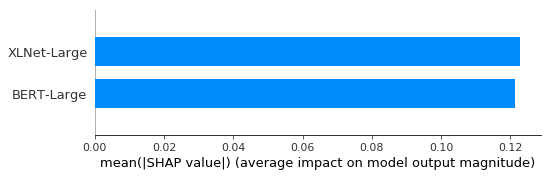

In [61]:
inds = np.random.choice(df_features_test.shape[0], 30, replace=False)
shap_values = explainer.shap_values(df_features_test.iloc[inds])
shap.summary_plot(shap_values, df_features_test.iloc[inds], plot_type="bar")

In [2]:
!jupyter nbconvert --to html Meta_regression.ipynb

[NbConvertApp] Converting notebook Meta_regression.ipynb to html
[NbConvertApp] Writing 349612 bytes to Meta_regression.html
